In [307]:
import importlib
import models
importlib.reload(models)

import pickle
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median
import numpy as np
from numpy.linalg import slogdet

In [308]:
def max_degree(G):
    # Initialize max_degree
    max_degree = -1

    # Iterate over all nodes and their degrees
    for degree in G.degree():
        if degree[1] > max_degree:
            max_degree = degree[1]
    
    return max_degree

In [309]:
df = pd.read_csv("model_one_desired_avg_deg.csv")
df = df[["num_vertices", "rand_seed"]].drop_duplicates()

new_vert = [200, 400, 600, 800, 1000, 1400, 1800] #, 1800, 2000, 2500]
for vert in new_vert:
    for seed in df["rand_seed"].unique()[0:2]:
        new_row = pd.DataFrame([{'num_vertices': vert, 'rand_seed': seed}])
        df = pd.concat([df, new_row], ignore_index=True)

In [310]:
# Check if planar and connected
planar = []
connected = []
avg_deg = []
median_deg = []
max_deg = []

#spanning tree information
num_nodes = []
tree_const = []
log_trees = []


for index, row in df.iterrows():
    n = int(row["num_vertices"])
    rs = int(row["rand_seed"])
    
    # CHOOSE MODEL
    model = "8"
    G = models.model_eight(n, rs, scaling_factor=0.3, remove_prob=0.05)

    # Planar?
    planar.append(nx.check_planarity(G)[0])
    
    # Connected?
    connected.append(nx.is_connected(G))

    # Calculate avg degree of graph
    avg_deg.append(2 * G.number_of_edges() / G.number_of_nodes())
    
    # Calculate median degree of graph
    degrees = sorted([degree for _, degree in G.degree()], reverse=False)
    median_deg.append(median(degrees))

    # Calculate max degree
    max_deg.append(max_degree(G))
    
    # calculate graph Laplacian
    print(f'calculating model {model}:', n, rs)
    Lap = nx.laplacian_matrix(G).toarray()
    T = np.delete(Lap,1,0)
    T = np.delete(T,1,1)
    (sign, logabsdet) = slogdet(T)
    if (sign == 1):
        tree_const.append(logabsdet/n)
        num_nodes.append(n)
        log_trees.append(logabsdet)

calculating model 8: 20 9
calculating model 8: 20 13
calculating model 8: 20 23
calculating model 8: 20 47
calculating model 8: 20 49
calculating model 8: 20 50
calculating model 8: 20 69
calculating model 8: 30 9
calculating model 8: 30 13
calculating model 8: 30 23
calculating model 8: 30 47
calculating model 8: 30 49
calculating model 8: 30 50
calculating model 8: 30 69
calculating model 8: 40 9
calculating model 8: 40 13
calculating model 8: 40 23
calculating model 8: 40 47
calculating model 8: 40 49
calculating model 8: 40 50
calculating model 8: 40 69
calculating model 8: 50 9
calculating model 8: 50 13
calculating model 8: 50 23
calculating model 8: 50 47
calculating model 8: 50 49
calculating model 8: 50 50
calculating model 8: 50 69
calculating model 8: 100 9
calculating model 8: 100 13
calculating model 8: 100 23
calculating model 8: 100 47
calculating model 8: 100 49
calculating model 8: 100 50
calculating model 8: 100 69
calculating model 8: 200 9
calculating model 8: 200 1

In [311]:
model_df = df.assign(planar=planar, connected=connected, 
                            avg_deg=avg_deg, median_deg=median_deg, max_deg=max_deg)

In [312]:
# Calculate the average of planar, connected, median_deg, max_deg
columns_avg = model_df[['planar', 'connected', 'avg_deg', 'median_deg', 'max_deg']].mean()
columns_avg["avg_st_con"] = st_cons=np.mean(tree_const)
columns_avg.round(2)

planar         0.00
connected      1.00
avg_deg        5.49
median_deg     5.40
max_deg       10.16
avg_st_con     1.45
dtype: float64

In [313]:
# avg deg 5.4
# st con 1.33

In [316]:
# Save the lists as pickles so I do not have to run the code each time
with open(f'pkls/num_nodes_m{model}.pkl', 'wb') as f:
    pickle.dump(num_nodes, f)
with open(f'pkls/tree_const_m{model}.pkl', 'wb') as f:
    pickle.dump(tree_const, f)
with open(f'pkls/log_trees_m{model}.pkl', 'wb') as f:
    pickle.dump(log_trees, f)

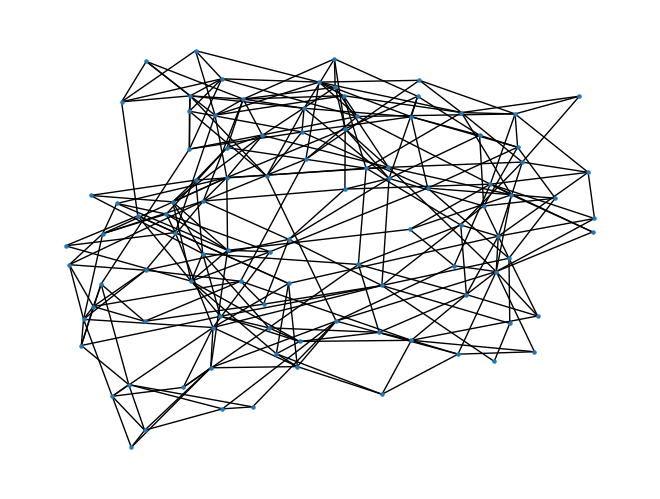

In [315]:
#G = models.model_two_rand_removal(100, 69, scaling_factor=14, remove_prob=0.6)
G = models.model_eight(100, 69, scaling_factor=0.3, remove_prob=0.05)
nx.draw(G, node_size = 5)